# Example: parameter fitting of an ODE

In this example, we estimate the values and covariances of $m$, $r$, $r_2$ and $k$ of a simple, forced nonlinear mass-spring-damper system
$$
m ẍ +  r ẋ + r_2 ẋ |ẋ| + k x = u.
$$
We measure only the position $x$ in millimeters, so the measurement equation is
$y = 1000x$.
Further, we have some prior knowledge of the system in terms of value bounds for the unknown parameters:
$$
\begin{align}
m &\in \mathbb R \\
r &\in [0, \infty) \\
r_2 &\in [0.01, 1] \\
k &\in [0.001, 2]
\end{align}
$$


In [1]:
import diffrax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

from dynax import (
    boxed_field,
    DynamicalSystem,
    fit_least_squares,
    Flow,
    non_negative_field,
    pretty,
    static_field,
)


np.random.seed(42)

Setting jax_enable_x64 to True.


Use `DynamicalSystem`, a subclass of `eqinox.Module`, to define the ODE. Bounds for trainable parameters can be specified using `boxed_field` and  `non_negative_field`. Fields that should not be trained can be marked with `static_field`. 

In [2]:
class NonlinearDrag(DynamicalSystem):
    # Declare parameters as dataclass fields.
    m: float
    r: float = non_negative_field()
    r2: float = boxed_field(lower=0.01, upper=1)
    k: float = boxed_field(lower=1e-3, upper=2)
    id: int = static_field(default=1234)

    # Set the number of states (order of system), the number of in- and outputs.
    n_states = 2
    n_inputs = 1
    n_outputs = 1

    # Define the the vector field of the dynamical system
    def vector_field(self, x, u, t):
        x1, x2 = x
        u = jnp.atleast_1d(u)
        return jnp.array(
            [
                x2,
                (-self.r * x2 - self.r2 * jnp.abs(x2) * x2 - self.k * x1 + u[0])
                / self.m,
            ]
        )

    def output(self, x, u, t):
        return x[0]

We combine an instance of the dynamical system with an ODE solver via the `Flow` class.

In [3]:
true_system = NonlinearDrag(m=1.0, r=2.0, r2=0.15, k=1.0)
true_model = Flow(
    true_system,
    solver=diffrax.Dopri8(),
    step=diffrax.PIDController(rtol=1e-3, atol=1e-6),
)
print("true forward model:", true_model)

true forward model: Flow(
  system=NonlinearDrag(
    n_states(static)=2,
    n_inputs(static)=1,
    n_outputs(static)=1,
    m=1.0,
    r(boxed: (0.0, inf))=2.0,
    r2(boxed: (0.01, 1))=0.15,
    k(boxed: (0.001, 2))=1.0,
    id(static)=1234
  ),
  solver(static)=Dopri8(scan_kind=None),
  step(static)=PIDController(
    rtol=0.001,
    atol=1e-06,
    pcoeff=0,
    icoeff=1,
    dcoeff=0,
    dtmin=None,
    dtmax=None,
    force_dtmin=True,
    step_ts=None,
    jump_ts=None,
    factormin=0.2,
    factormax=10.0,
    norm=<function rms_norm>,
    safety=0.9,
    error_order=None
  ),
  dt0(static)=None
)


Note that attributes denoted by "static" are not trained.

Let's create some data from some random input by directly calling the model instance.

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


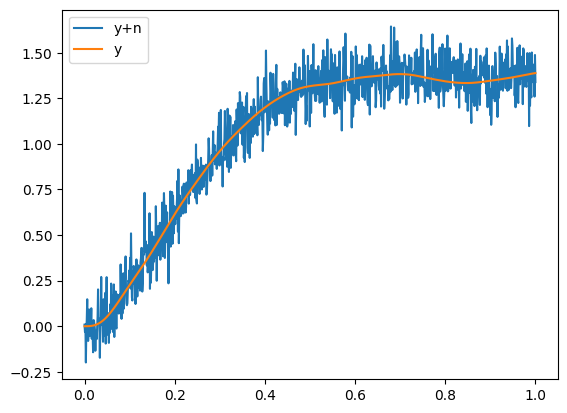

In [4]:
t = np.linspace(0, 1, 1000)
samplerate = 1 / t[1]
u = 1 * np.sum(
    np.stack(
        [np.sin(2 * np.pi * f * t) for f in np.random.uniform(1, 10, 100)], axis=0
    ),
    axis=0,
)
# zero initial state
x0 = [0.0, 0.0]
# x are the states and y is the output
x, y = true_model(x0, t, u)
# add noise to measurement
yn = y + np.random.normal(size=y.shape, scale=0.1)

plt.plot(t, yn, label="y+n")
plt.plot(t, y, label="y")
plt.legend()

Create dynamical system with some initial parameters for training.

In [5]:
initial_sys = NonlinearDrag(m=1.0, r=1.0, r2=1.0, k=1.0)
print("initial system:", initial_sys)

initial system: NonlinearDrag(
  n_states(static)=2,
  n_inputs(static)=1,
  n_outputs(static)=1,
  m=1.0,
  r(boxed: (0.0, inf))=1.0,
  r2(boxed: (0.01, 1))=1.0,
  k(boxed: (0.001, 2))=1.0,
  id(static)=1234
)


Combine the initial ODE system with an ODE solver and fit it using nonlinear Least-Squares.

In [6]:
init_model = Flow(initial_sys)
res = fit_least_squares(model=init_model, t=t, y=yn, x0=x0, u=u, verbose=2)
pred_model = res.model
print("fitted system:", pretty(pred_model.system))
print("Normalized mean squared error:", res.nrmse)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.3501e-01                                    1.04e+00    
       1              2         9.1472e-02      3.44e-01       5.02e-01       2.50e-01    
       2              3         4.9851e-02      4.16e-02       2.88e-01       8.95e-02    
       3              4         4.6368e-02      3.48e-03       6.43e-02       1.10e-02    
       4              5         4.6061e-02      3.07e-04       2.68e-01       7.65e-04    
       5              6         4.6031e-02      3.00e-05       1.32e-01       6.32e-05    
       6              7         4.6022e-02      8.50e-06       3.54e-01       3.09e-04    
       7              8         4.6022e-02      3.72e-07       2.96e-02       8.28e-06    
       8              9         4.6022e-02      3.73e-07       8.52e-02       1.67e-05    
       9             10         4.6022e-02      6.48e-09       9.99e-03       5.09e-07    

Compare true and estimated output.

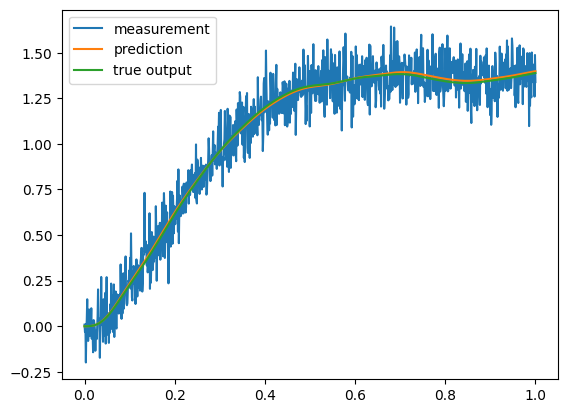

In [9]:
x_pred, _ = pred_model(x0, t, u)

plt.plot(t, yn, label="measurement")
plt.plot(t, res.y_pred, label="prediction")
plt.plot(t, y, label="true output")

plt.legend()
plt.show()

`fit_least_squares` also estimates the covariance matrix of the parameter estimates.

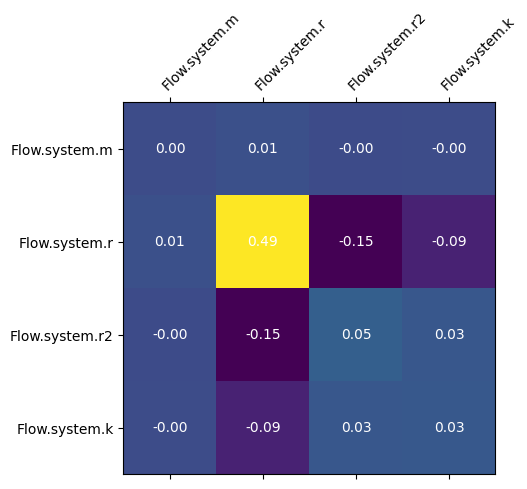

In [10]:
def plot_covariance(res):
    nparams = len(res.key_paths)

    plt.matshow(res.pcov)
    ax = plt.gca()
    ax.set_xticks(np.arange(nparams), labels=res.key_paths)
    ax.set_yticks(np.arange(nparams), labels=res.key_paths)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")

    for i in range(nparams):
        for j in range(nparams):
            ax.text(j, i, f"{res.pcov[i, j]:.2f}", ha="center", va="center", color="w")


plot_covariance(res)

The parameter standard deviations are:

In [11]:
for kp, var in zip(res.key_paths, np.diag(res.pcov)):
    print(f"{kp}: {np.sqrt(var):.3f}")

Flow.system.m: 0.016
Flow.system.r: 0.701
Flow.system.r2: 0.214
Flow.system.k: 0.163
